In [173]:
#!pip install fitz
#!pip install PyMuPDF
#!pip install requests requests-aws4auth opensearch-py Pillow
#!pip install faiss-cpu  # for CPU-only version
# or


In [174]:
#!pip install langchain ipython tqdm 
#!pip install tabula-py


In [175]:
import boto3
import base64
from PIL import Image
import io
import json
import fitz
import uuid
import requests
from requests_aws4auth import AWS4Auth
import faiss
import sagemaker
from PIL import Image
from typing import List
import os
from IPython import display
import pymupdf
from botocore.exceptions import ClientError
from langchain.text_splitter import RecursiveCharacterTextSplitter
import warnings
from tabula.io import read_pdf
from pathlib import Path
import numpy as np

In [176]:
role = sagemaker.get_execution_role()
role

'arn:aws:iam::117134819170:role/service-role/AmazonSageMaker-ExecutionRole-20241217T165645'

In [177]:
# Downloading the dataset - URL of the "Attention Is All You Need" paper (Replace it with the URL of the PDF file/dataset you want to download)
url = "https://arxiv.org/pdf/1706.03762.pdf"

# Set the filename and filepath
filename = "attention_paper.pdf"

filepath = os.path.join("data", filename)
os.makedirs("data", exist_ok=True)

response = requests.get(url)
if response.status_code == 200:
    with open(filepath, 'wb') as file:
        file.write(response.content)
    print(f"file downloaded successfully: {filepath}")
else:
    print(f"Failed to download the file. Status code {response.status_code_}")# Downloading the dataset - URL of the "Attention Is All You Need" paper (Replace it with the URL of the PDF file/dataset you want to download))

file downloaded successfully: data/attention_paper.pdf


In [178]:
display.IFrame(filepath, width=1000, height=600)


## Data Extraction

In [238]:
import pymupdf
from pathlib import Path
from tqdm import tqdm
import base64
from langchain.text_splitter import RecursiveCharacterTextSplitter

def process_pdf(filepath, filename):
    doc = pymupdf.open(filepath)
    num_pages = len(doc)
    
    # Define directories
    image_save_dir = Path("data/processed_images")
    text_save_dir = Path("data/processed_text")
    table_save_dir = Path("data/processed_tables")
    page_images_save_dir = Path("data/processed_page_images")
    
    # Create directories if they don't exist
    for directory in [image_save_dir, text_save_dir, table_save_dir, page_images_save_dir]:
        directory.mkdir(parents=True, exist_ok=True)
    
    # Configure text splitter
    chunk_size = 700
    overlap = 200
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
        length_function=len,
    )
    
    items = []
    
    for page_num in tqdm(range(num_pages), desc="Processing pdf pages"):
        page = doc[page_num]
        text = page.get_text()

        try:
            # Process text chunks
            chunks = text_splitter.split_text(text)
            
            for i, chunk in enumerate(chunks):
                text_file_name = text_save_dir / f"{filename}_text_{page_num}_{i}.txt"
                text_file_name.parent.mkdir(parents=True, exist_ok=True)
                
                with open(text_file_name, 'w', encoding='utf-8') as f:
                    f.write(chunk)
                
                item = {
                    'page': page_num,
                    'type': "text",
                    'text': chunk,
                    'path': str(text_file_name)
                }
                items.append(item)
            
            # Process images
            images = page.get_images()
            
            for idx, image in enumerate(images):
                xref = image[0]
                pix = pymupdf.Pixmap(doc, xref)
                
                image_name = image_save_dir / f"{filename}_image_{page_num}_{idx}_{xref}.png"
                pix.save(str(image_name))
                
                with open(image_name, 'rb') as f:
                    image_data = base64.b64encode(f.read()).decode('utf-8')
                
                item = {
                    "page": page_num,
                    "type": "image",
                    "path": str(image_name),
                    "image": image_data
                }
                items.append(item)
                
            pix = page.get_pixmap()
            
            page_path = page_images_save_dir / f"page_{page_num:03d}.png"
            pix.save(page_path)

            with open(page_path, 'rb') as f:
                page_image = base64.b64encode(f.read()).decode('utf-8')

            item = {}
            item['page'] = page_num
            item['type'] = "page"
            item['path'] = page_path
            item['image'] = page_image
            items.append(item)

        except Exception as e:
            print(f"Error processing page {page_num}: {str(e)}")
            continue

    doc.close()
    return items

# Usage
items = process_pdf("data/hotel-brochure.pdf", "hotel-brochure.pdf")

Processing pdf pages: 100%|██████████| 21/21 [00:12<00:00,  1.71it/s]


## Generating Multimodal Embeddings

In [239]:
def generate_multimodal_embeddings(prompt=None, image=None, output_embedding_length=384):
    if not prompt and not image:
        raise ValueError("Please provide either text prompt , base 64 image or both as input")

    client = boto3.client(service_name="bedrock-runtime")
    model_id = "amazon.titan-embed-image-v1"
    body = {
        "embeddingConfig": {"outputEmbeddingLength": output_embedding_length,
                           },

    }
            

    if prompt:
        body["inputText"] = prompt
    if image:
        body["inputImage"]= image

    try:
        response = client.invoke_model(
            modelId=model_id,
            body=json.dumps(body),
            accept="application/json",
            contentType="application/json"
        )
        result = json.loads(response.get("body").read())
        return result.get("embedding")
    except ClientError as er:
        print(f"Error while invoking embeddings model {er.response['Error']['Message']}")
        return None
        
            
            
    

In [248]:
def resize_image_if_needed(image_input, max_pixels=1024*1024):
    try:
        if isinstance(image_input, str) and image_input.startswith('iVBOR'):
            img_bytes = base64.b64decode(image_input)
        else:
            img_bytes = image_input

        img = Image.open(io.BytesIO(img_bytes))
        
        current_pixels = img.width * img.height
        if current_pixels > max_pixels:
            ratio = (max_pixels / current_pixels) ** 0.5
            new_size = (int(img.width * ratio), int(img.height * ratio))
            img = img.resize(new_size, Image.Resampling.LANCZOS)
        
        buffered = io.BytesIO()
        img.save(buffered, format='PNG')
        return base64.b64encode(buffered.getvalue()).decode('utf-8')
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None

In [249]:
import faiss
import numpy as np
from tqdm import tqdm

# Define embedding dimension
output_embedding_length = 384

# Track item counts
item_counts = {
    "text": sum(1 for item in items if item['type'] == 'text'),
    "image": sum(1 for item in items if item['type'] == 'image'),
    "page": sum(1 for item in items if item['type'] == 'page')
}
counters = dict.fromkeys(item_counts.keys(), 0)

# Generate embeddings
all_embeddings = []  # Create list to store all embeddings

with tqdm(total=len(items), desc="Generating Embeddings", 
          bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]") as pbar:
    for item in items:
        item_type = item['type']
        counters[item_type] += 1
        
        # Generate embedding based on type
        if item_type == 'text':
            embedding = generate_multimodal_embedding(prompt=item['text'], 
                                                   output_embedding_length=output_embedding_length)
        else:
            item['image'] = resize_image_if_needed(item['image'])
            embedding = generate_multimodal_embedding(image=item['image'], 
                                                   output_embedding_length=output_embedding_length)
            
        item['embedding'] = embedding
        all_embeddings.append(embedding)  # Add embedding to list
        
        pbar.set_postfix_str(f"Text: {counters['text']}/{item_counts['text']}, "
                            f"Image: {counters['image']}/{item_counts['image']}")
        pbar.update(1)

# Convert embeddings to numpy array
all_embeddings = np.array(all_embeddings, dtype=np.float32)

# Initialize and populate FAISS index
index = faiss.IndexFlatL2(output_embedding_length)
index.add(all_embeddings)



Generating Embeddings: 100%|██████████| 78/78 [00:46<00:00]


In [250]:
# Generating rag response with Nova 

def invoke_nova_multimodal(prompt, matched_items):
    system_msg = [

        {
            "text": """ You are helpful assitant in answering questions in text format and returning relevant images.
            The text context is relevant information retrieved.
            The provided image are relevant information retrieved 
             """
        }

    ]
    message_content = []
    for item in matched_items:
        if item['type'] == 'text':
            message_content.append({
                    "text": item["text"]
                })
        elif item['type'] == 'image':
            message_content.append({
                    "image": {
                        "format": "png",
                        "source": {
                            "bytes": item['image']
                        }
                    }
                })

    inf_params = {
                "max_new_tokens": 300,
                "top_p": 0.9,
                "top_k": 20,
                "temperature": 0.7

        }

    messages = [
        {
            "role": "user",
            "content": message_content
        },
        {
            "role": "user",
            "content": [{"text": prompt}]  # Fixed: Use the actual prompt parameter
        }
    ]
    native_request = {
        "messages": messages,
        "system": system_msg,
        "inferenceConfig": inf_params


    }

    client = boto3.client(service_name = "bedrock-runtime")
    model_id = "amazon.nova-pro-v1:0"

    response = client.invoke_model(modelId = model_id, body = json.dumps(native_request))
    model_response = json.loads(response["body"].read())

    return model_response
    


In [251]:
# User Query
query = "Show me image of hall"

query_embedding = generate_multimodal_embeddings(prompt=query, output_embedding_length=384)
query_embedding_arr = np.array(query_embedding, dtype=np.float32).reshape(1, -1)
distances, results = index.search(query_embedding_arr, k=5)



# Check the result (matched chunks)
result.flatten()

In [252]:
result

array([[10, 17, 61, 14, 73]])

In [253]:
result_array = result.flatten()

matched_items = []

for index in result_array:
    item = items[index]
    filter_item = {k:v for k, v in item.items() if k != 'embedding' }
    matched_items.append(filter_item)
    
matched_items

response = invoke_nova_multimodal(query, matched_items)
response



{'output': {'message': {'content': [{'text': 'Here is an image of a hall with a modern design. It features large, abstract ceiling lights, a mix of wooden and upholstered furniture, and a sophisticated color palette. The space appears to be a dining area with tables set for a meal, suggesting it could be part of a restaurant or a large event space.'}],
   'role': 'assistant'}},
 'stopReason': 'end_turn',
 'usage': {'inputTokens': 3468, 'outputTokens': 63, 'totalTokens': 3531}}

In [254]:
final_response = response['output']['message']['content'][0]['text']
display.Markdown(final_response)

Here is an image of a hall with a modern design. It features large, abstract ceiling lights, a mix of wooden and upholstered furniture, and a sophisticated color palette. The space appears to be a dining area with tables set for a meal, suggesting it could be part of a restaurant or a large event space.

## Display images based off query

In [267]:
img_list = []
for matched_item in matched_items:
    img_string = matched_item['image']
    img_bytes = base64.b64decode(img_string)
    img_list.append(Image.open(io.BytesIO(img_bytes)))
 

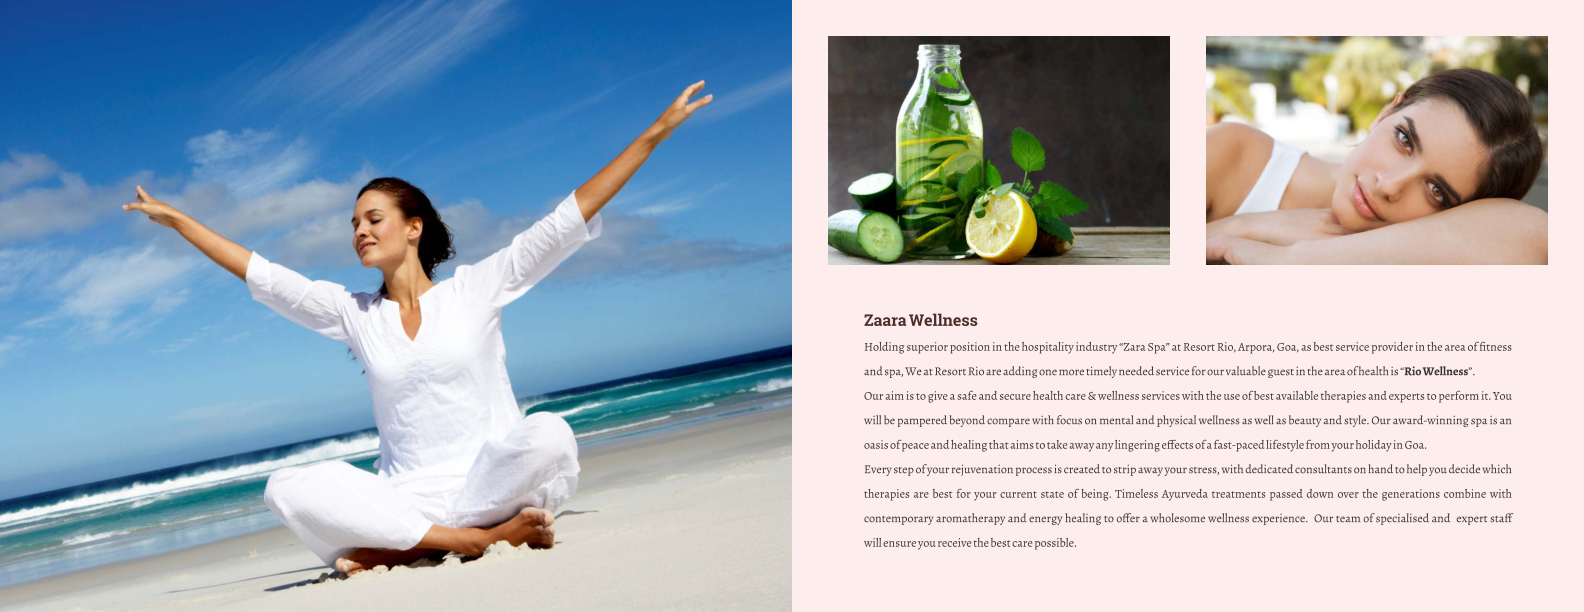

In [271]:
img_list[2]

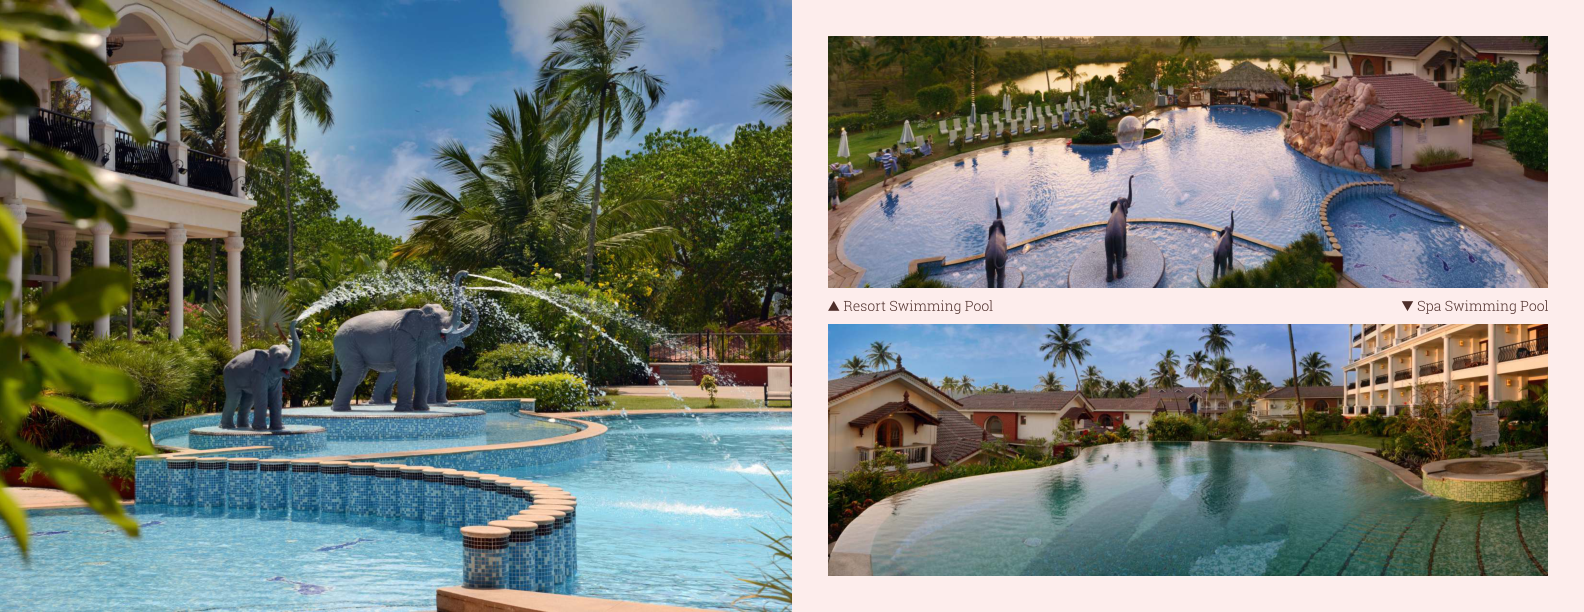

In [263]:
img